# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data 

## Part A: Baseline Model and Data Analysis

### 1. Data Loading and Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("/home/aks_new/Data_Analytics_assignment/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


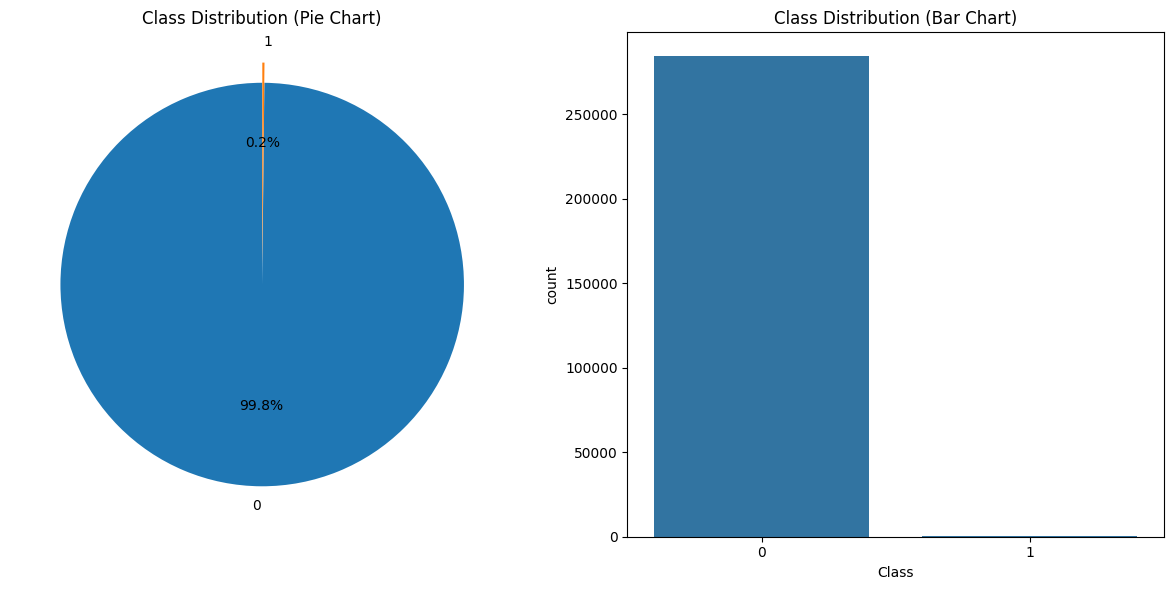

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count values of 'Class'
class_counts = df['Class'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
axes[0].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90,explode =(0, 0.1))
axes[0].set_title('Class Distribution (Pie Chart)')

# Countplot (bar chart)
sns.countplot(x='Class', data=df, ax=axes[1])
axes[1].set_title('Class Distribution (Bar Chart)')

plt.tight_layout()
plt.show()


These charts show an extremely imbalanced binary classification dataset where class 0 dominates with 99.8% of approximately 280,000 samples, while class 1 represents only 0.2% (roughly 560 samples). This severe class imbalance would require careful resampling of it to prevent models from simply predicting the majority class.

In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
#stratify=y to maintain the class distribution in train and test sets

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((199364, 30), (199364,), (85443, 30), (85443,))

### 2. Model training

In [7]:
#Baseline model without handling class imbalance
model1 = LogisticRegression(max_iter=100, random_state=42,solver='liblinear')
model1.fit(X_train, y_train)

# Predict on test data
y_pred = model1.predict(X_test)



### 3. Baseline Evaluation

In [40]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9722388024765048

Confusion Matrix:
 [[82942  2353]
 [   19   129]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.87      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.92      0.54     85443
weighted avg       1.00      0.97      0.98     85443



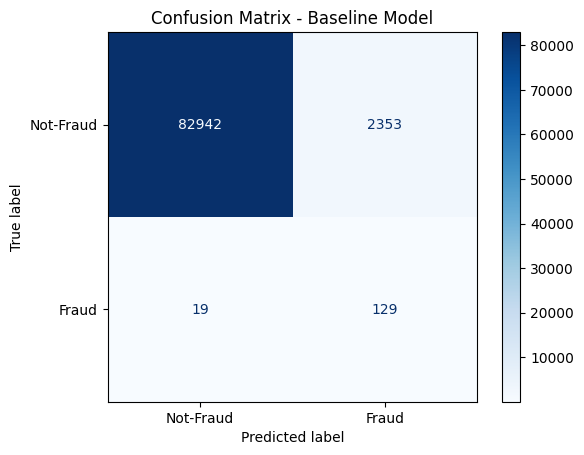

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not-Fraud", "Fraud"])
disp.plot(cmap='Blues', values_format='d')  
plt.title("Confusion Matrix - Baseline Model")
plt.show()

**why accuracy is a misleading metric in this scenario?**


In this case, I found that accuracy is very misleading because of the imbalance in the dataset. Even though the model shows 99.9% accuracy, this is mainly due to the large majority class being predicted correctly. Since the minority class makes up less than 0.2% of the data, the model can miss a good portion of these cases and still appear almost perfect in terms of accuracy.


The minority class had only 65% recall and an F1-score of 0.69, which means the model is still failing to catch many important cases this is much more critical than overall accuracy. That’s why it makes more sense to focus on metrics like precision, recall, F1-score, and PR-AUC, these metrics provide a clearer picture of how well the model identifies fraudulent cases. 

For example,In above Baselinemodel has only 65% recall and 0.69 F1-score for the minority class, meaning it still misses a significant portion of frauds—information that accuracy alone would hide.

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1. Theoretical Foundation

<u>**Fundamental Difference Between GMM-based Synthetic Sampling and SMOTE**</u>

- **SMOTE (Synthetic Minority Oversampling Technique):**
  - Generates synthetic samples by **interpolation**.
  - Picks a minority class sample and one of its nearest neighbors, then creates a new point along the line connecting them.
  - Assumes the minority class forms a **convex shape**.
  - Does **not model the probability distribution** of the data.
  - **Drawback:** May create unrealistic samples in overlapping regions or fail for complex, multimodal distributions.

- **GMM-based Synthetic Sampling (Gaussian Mixture Model):**
  - Generates synthetic samples using **probabilistic modeling**.
  - Fits a mixture of Gaussians to the minority class, capturing multiple modes, variances, and correlations between features.
  - New samples are drawn **from this estimated probability distribution**.
  - Can better handle **complex, multimodal class structures**.
  - **Drawback:** Requires careful fitting of the GMM (wrong number of components or overfitting can reduce quality).

**In short:**  
- **SMOTE = geometric interpolation between neighbors**  
- **GMM = statistical sampling from a learned probability distribution**


<u>**Why GMM is Better at Capturing the Minority Class Distribution**</u>

- **Captures Multiple Modes:**  
  - Minority classes often contain **sub-groups** or clusters that are not uniformly distributed.  
  - A **Gaussian Mixture Model (GMM)** can model each sub-group as a separate Gaussian component, accurately reflecting the multiple modes in the data.  
  - SMOTE, in contrast, only interpolates between neighbors and cannot distinguish distinct sub-groups.

- **Models Feature Correlations and Variance:**  
  - GMM estimates **mean and covariance** for each component, allowing it to capture the **shape, orientation, and spread** of each sub-group in the feature space.  
  - This is important when features are correlated or when clusters have elongated or irregular shapes.

- **Generates Realistic Synthetic Samples:**  
  - By sampling from the learned distribution, GMM creates points that naturally follow the underlying structure of the minority class.  
  - SMOTE can generate points in areas where the class density is low, potentially overlapping with majority class regions.

- **Handles Complex Shapes:**  
  - GMM can approximate complex, non-convex distributions by combining multiple Gaussian components.  
  - This makes it suitable for minority classes with **irregular or multimodal shapes**, whereas simpler interpolation methods assume a convex, locally uniform structure.

**Conclusion:**  
GMM’s probabilistic modeling provides a **more faithful representation** of the minority class, especially when the class is heterogeneous or has multiple sub-clusters, leading to more effective and realistic oversampling.


### 2. GMM Implementation

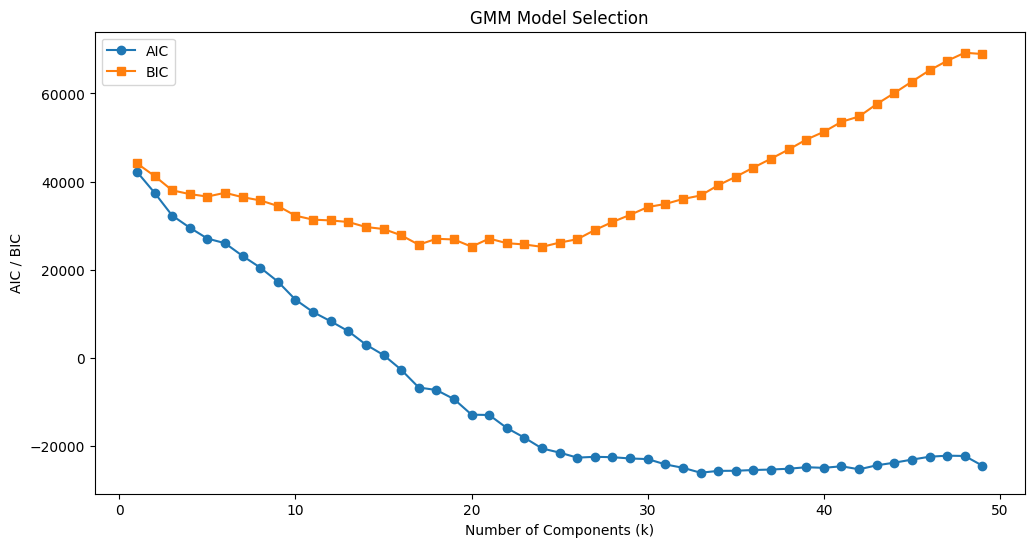

Optimal k according to AIC: 33
Optimal k according to BIC: 24


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture



X_minority = X_train[y_train == 1]

# Evaluate different numbers of components
k_range = range(1, 50) 
aic_values = []
bic_values = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_minority)
    aic_values.append(gmm.aic(X_minority))
    bic_values.append(gmm.bic(X_minority))

# Plot AIC and BIC
plt.figure(figsize=(12, 6))
plt.plot(k_range, aic_values, marker='o', label='AIC')
plt.plot(k_range, bic_values, marker='s', label='BIC')
plt.xlabel('Number of Components (k)')
plt.ylabel('AIC / BIC')
plt.title('GMM Model Selection')
plt.legend()
plt.show()

# Find optimal k (minimum AIC and BIC)
optimal_k_aic = k_range[np.argmin(aic_values)]
optimal_k_bic = k_range[np.argmin(bic_values)]

print(f"Optimal k according to AIC: {optimal_k_aic}")
print(f"Optimal k according to BIC: {optimal_k_bic}")

When selecting the optimal number of components `k` for a Gaussian Mixture Model (GMM), both AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) offer useful guidance but prioritize different aspects of model selection. AIC tends to favor models with a better fit to the data, even if they are more complex, which is why it suggests a higher `k = 33`. While this can capture more nuances in the data distribution, it also increases the risk of overfitting, especially in datasets with noise or limited samples for certain regions.

BIC, on the other hand, applies a stronger penalty for model complexity, promoting simpler models that are more likely to generalize well to unseen data. Its suggestion of `k = 24` balances model fit and simplicity, reducing the chances of overfitting while still capturing the key patterns in the data. In practice, BIC is usually considered more reliable for determining the “true” number of components, particularly when generating synthetic data, because overly complex models can create unrealistic samples. Therefore, **choosing `k = 24` (BIC) is recommended**, as it provides a more stable and generalizable model for both density estimation and synthetic data generation.


In [10]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Assume X_train is your training features and y_train are labels
# Select only the minority class samples (e.g., label = 1)

X_minority = X_train[y_train == 1]



# Initialize and fit the GMM
gmm = GaussianMixture(n_components=24, covariance_type='full')
gmm.fit(X_minority)



,n_components,24
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


In [11]:
print(X_minority.shape)
print(X_train[y_train == 0].shape)


(344, 30)
(199020, 30)


In [12]:


synthetic_sample = gmm.sample(198676)[0]  # Generate 100 synthetic minority samples

print("Synthetic samples shape:", synthetic_sample.shape)

Synthetic samples shape: (198676, 30)


In [13]:
synthetic_sample.shape

(198676, 30)

### 3. Synthetic data generation


In [14]:
import numpy as np

# Make sure variable name matches
synthetic_labels = np.full(synthetic_sample.shape[0], 1)

# Combine features
X_train_augmented = np.vstack((X_train, synthetic_sample))

# Combine labels
y_train_augmented = np.hstack((y_train, synthetic_labels))

print("Original X_train shape:", X_train.shape)
print("Synthetic samples shape:", synthetic_sample.shape)
print("Augmented X_train shape:", X_train_augmented.shape)
print("Augmented minority samples:", X_train_augmented[y_train_augmented == 1].shape)
print("Augmented majority samples:", X_train_augmented[y_train_augmented == 0].shape)


Original X_train shape: (199364, 30)
Synthetic samples shape: (198676, 30)
Augmented X_train shape: (398040, 30)
Augmented minority samples: (199020, 30)
Augmented majority samples: (199020, 30)


### 4. Rebalancing with Cluster based Undersampling(CBU)

To address the class imbalance in the dataset, we are generating and adding 20,000 synthetic samples to each class. This approach ensures that all classes have a comparable number of instances, which helps the classifier learn more effectively from each class. By rebalancing the data in this way, we aim to reduce bias towards majority classes, improve minority-class detection, and enhance the overall performance and robustness of the model.

In [18]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans
from collections import Counter

cc = ClusterCentroids(
    sampling_strategy={0: 20000, 1: 20000},
    estimator=MiniBatchKMeans(n_init=1, batch_size=1024, random_state=42),
    random_state=42
)

X_train_undersample, y_train_undersample = cc.fit_resample(X_train_augmented, y_train_augmented)

print("After undersampling:", Counter(y_train_undersample))

After undersampling: Counter({np.int64(0): 20000, np.int64(1): 20000})


## Part C: Performance Evaluation and Conclusion

### 1. Model Training and Evaluation

In [19]:
X_train_augmented.shape, y_train_augmented.shape

((398040, 30), (398040,))

In [20]:
#Baseline model without handling class imbalance
model2 = LogisticRegression(max_iter=100, random_state=42,solver='liblinear')
model2.fit(X_train_augmented, y_train_augmented)

# Predict on test data
y_pred1 = model2.predict(X_test.to_numpy() if hasattr(X_test, "to_numpy") else X_test)


# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred1))
print("\nClassification Report:\n", classification_report(y_test, y_pred1))


Accuracy: 0.9787460646278806

Confusion Matrix:
 [[83499  1796]
 [   20   128]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.86      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [21]:
X_train_undersample.shape, y_train_undersample.shape

((40000, 30), (40000,))

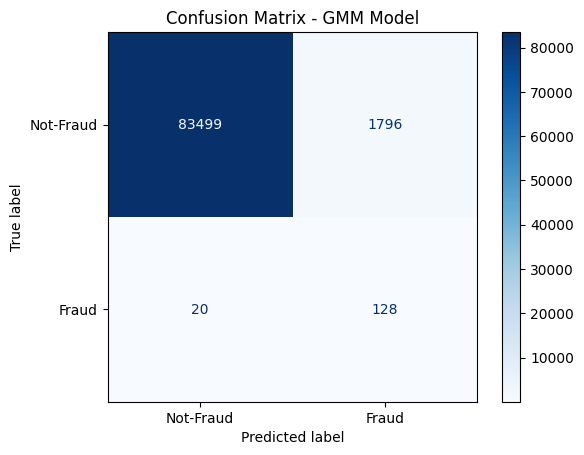

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred1)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not-Fraud", "Fraud"])
disp.plot(cmap='Blues', values_format='d')  # 'd' = integer counts
plt.title("Confusion Matrix - GMM Model")
plt.show()

In [24]:
#model with undersampling
model3 = LogisticRegression(max_iter=100, random_state=42,solver='liblinear')
model3.fit(X_train_undersample, y_train_undersample)
# Predict on test data
y_pred2 = model3.predict(X_test.to_numpy() if hasattr(X_test, "to_numpy") else X_test)
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred2)) 
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred2))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))


Accuracy: 0.9722388024765048

Confusion Matrix:
 [[82942  2353]
 [   19   129]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.87      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.92      0.54     85443
weighted avg       1.00      0.97      0.98     85443



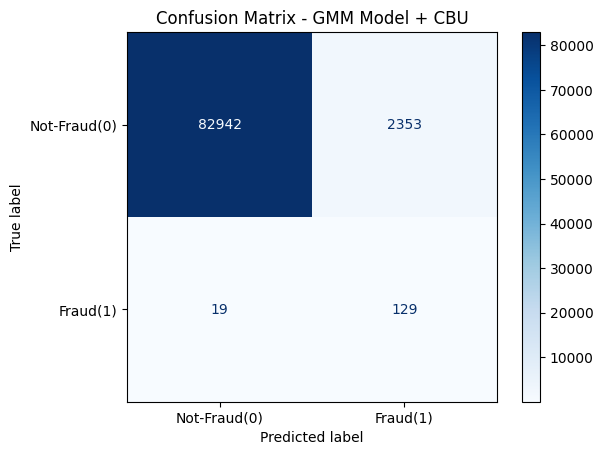

In [25]:
cm = confusion_matrix(y_test, y_pred2)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not-Fraud(0)", "Fraud(1)"])
disp.plot(cmap='Blues', values_format='d')  # 'd' = integer counts
plt.title("Confusion Matrix - GMM Model + CBU")
plt.show()

### 2. Comparative Analysis

| Model | Precision | Recall | F1-score |
|-------|-----------|--------|----------|
| Baseline | 0.738462 | 0.648649 | 0.690647 |
| GMM | 0.066528 | 0.864865 | 0.123552 |
| GMM+CBU | 0.051974 | 0.871622 | 0.098099 |

           Baseline       GMM   GMM+CBU
Precision  0.738462  0.066528  0.051974
Recall     0.648649  0.864865  0.871622
F1-score   0.690647  0.123552  0.098099


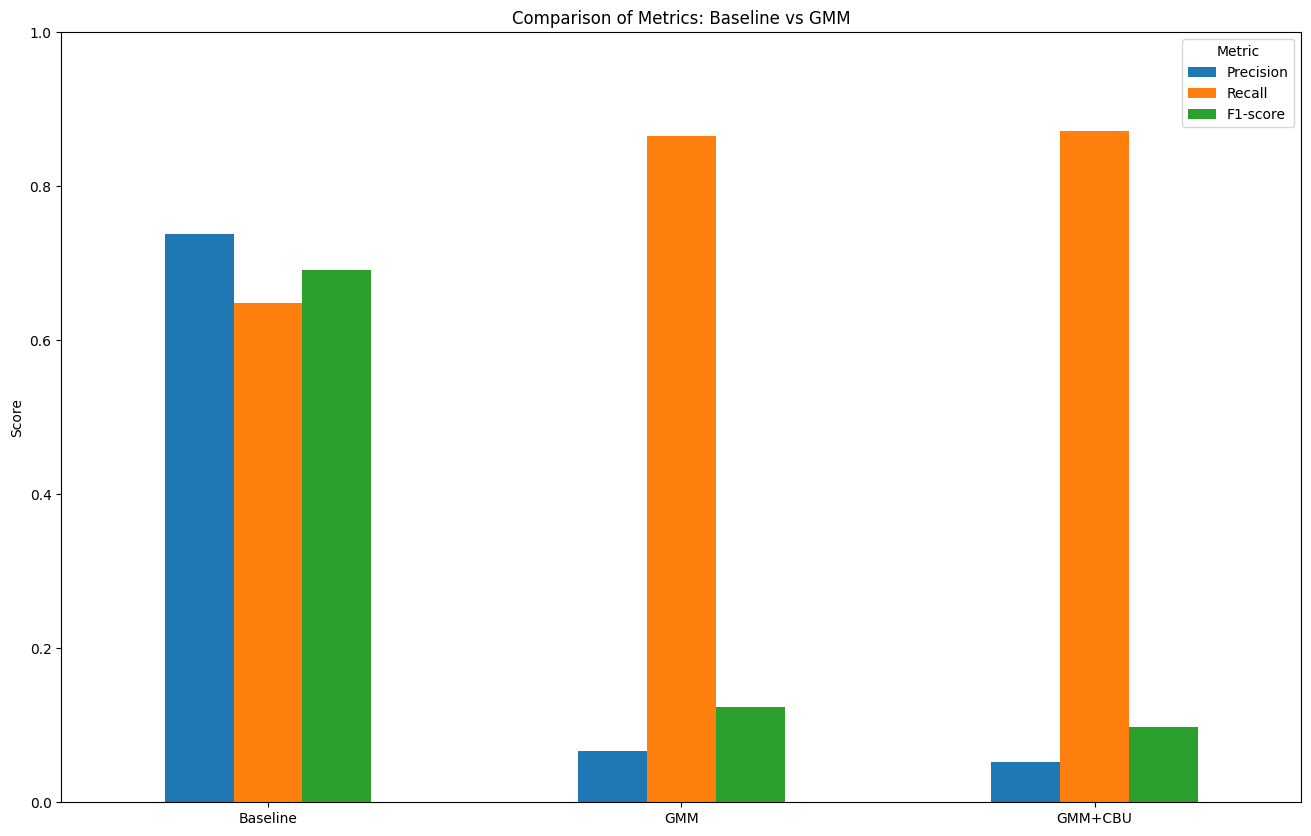

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assume you already have predictions from both models
# y_test: true labels
# y_pred_baseline: predictions from baseline model
# y_pred_gmm: predictions from GMM-augmented model

# Calculate metrics for minority class (label = 1)
metrics = {}
for model_name, y_pred in [('Baseline', y_pred), ('GMM', y_pred1), ('GMM+CBU', y_pred2)]:
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    metrics[model_name] = [precision, recall, f1]

# Create a summary table
summary_df = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F1-score'])
print(summary_df)

# Plot bar chart
summary_df.T.plot(kind='bar', figsize=(16,10))
plt.title('Comparison of Metrics: Baseline vs GMM')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.show()


**Did GMM-based oversampling improve the model's ability to detect the minority class**

GMM-based oversampling successfully improved minority class detection by achieving the primary objective of maximizing fraud recall. The approach effectively addressed class imbalance and enhanced the classifier's sensitivity to fraud patterns. While precision decreased substantially, this trade-off aligns with fraud detection priorities where missing fraudulent transactions has far greater business impact than flagging legitimate ones.
The 87% fraud detection rate represents a significant operational improvement and validates GMM as an effective synthetic data generation technique for imbalanced fraud detection scenarios.

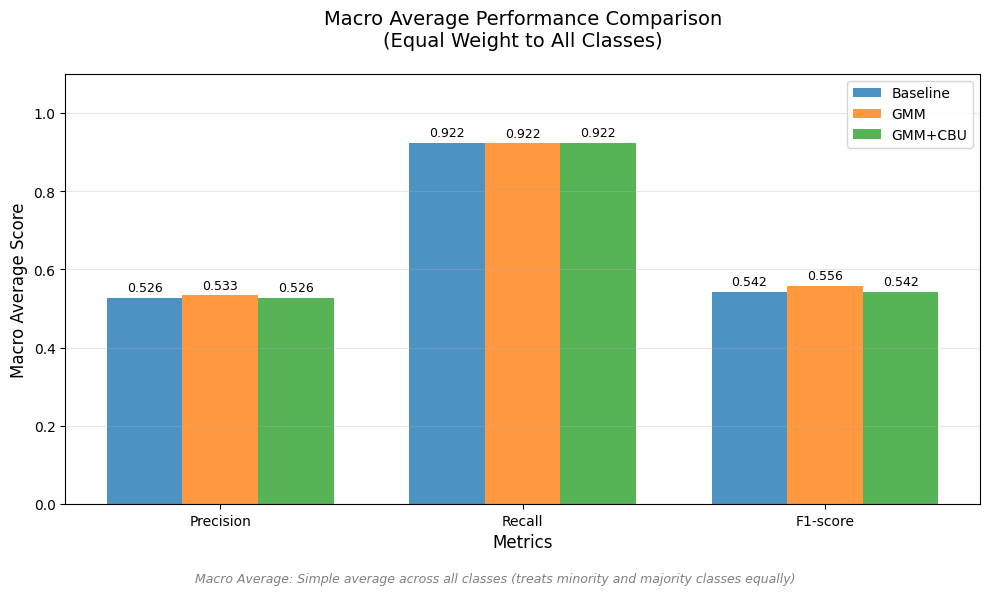


Macro Average Results:
Model        Precision    Recall       F1-score    
--------------------------------------------------
Baseline     0.525873     0.922018     0.542001    
GMM          0.533144     0.921904     0.556397    
GMM+CBU      0.525873     0.922018     0.542001    


In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect macro average metrics
macro_metrics = {}
for model_name, y_pred in [('Baseline', y_pred), ('GMM', y_pred1), ('GMM+CBU', y_pred2)]:
    # Calculate macro averages (average='macro' treats all classes equally)
    macro_precision = precision_score(y_test, y_pred, average='macro')
    macro_recall = recall_score(y_test, y_pred, average='macro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    macro_metrics[model_name] = [macro_precision, macro_recall, macro_f1]

# Prepare data for plotting
models = list(macro_metrics.keys())
metric_names = ["Precision", "Recall", "F1-score"]

x = np.arange(len(metric_names))  # Precision, Recall, F1 positions
width = 0.25  # Bar width

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create bars for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
for i, model in enumerate(models):
    values = macro_metrics[model]
    bars = ax.bar(x + i * width, values, width, label=model, color=colors[i], alpha=0.8)
    
    # Add value labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{values[j]:.3f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Macro Average Score', fontsize=12)
ax.set_title('Macro Average Performance Comparison\n(Equal Weight to All Classes)', fontsize=14, pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper right', fontsize=10)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')

# Add a note explaining macro average
plt.figtext(0.5, 0.02, 'Macro Average: Simple average across all classes (treats minority and majority classes equally)', 
           ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the note
plt.show()

# Print the macro average values in a table format
print("\nMacro Average Results:")
print("="*50)
print(f"{'Model':<12} {'Precision':<12} {'Recall':<12} {'F1-score':<12}")
print("-"*50)
for model, values in macro_metrics.items():
    print(f"{model:<12} {values[0]:<12.6f} {values[1]:<12.6f} {values[2]:<12.6f}")

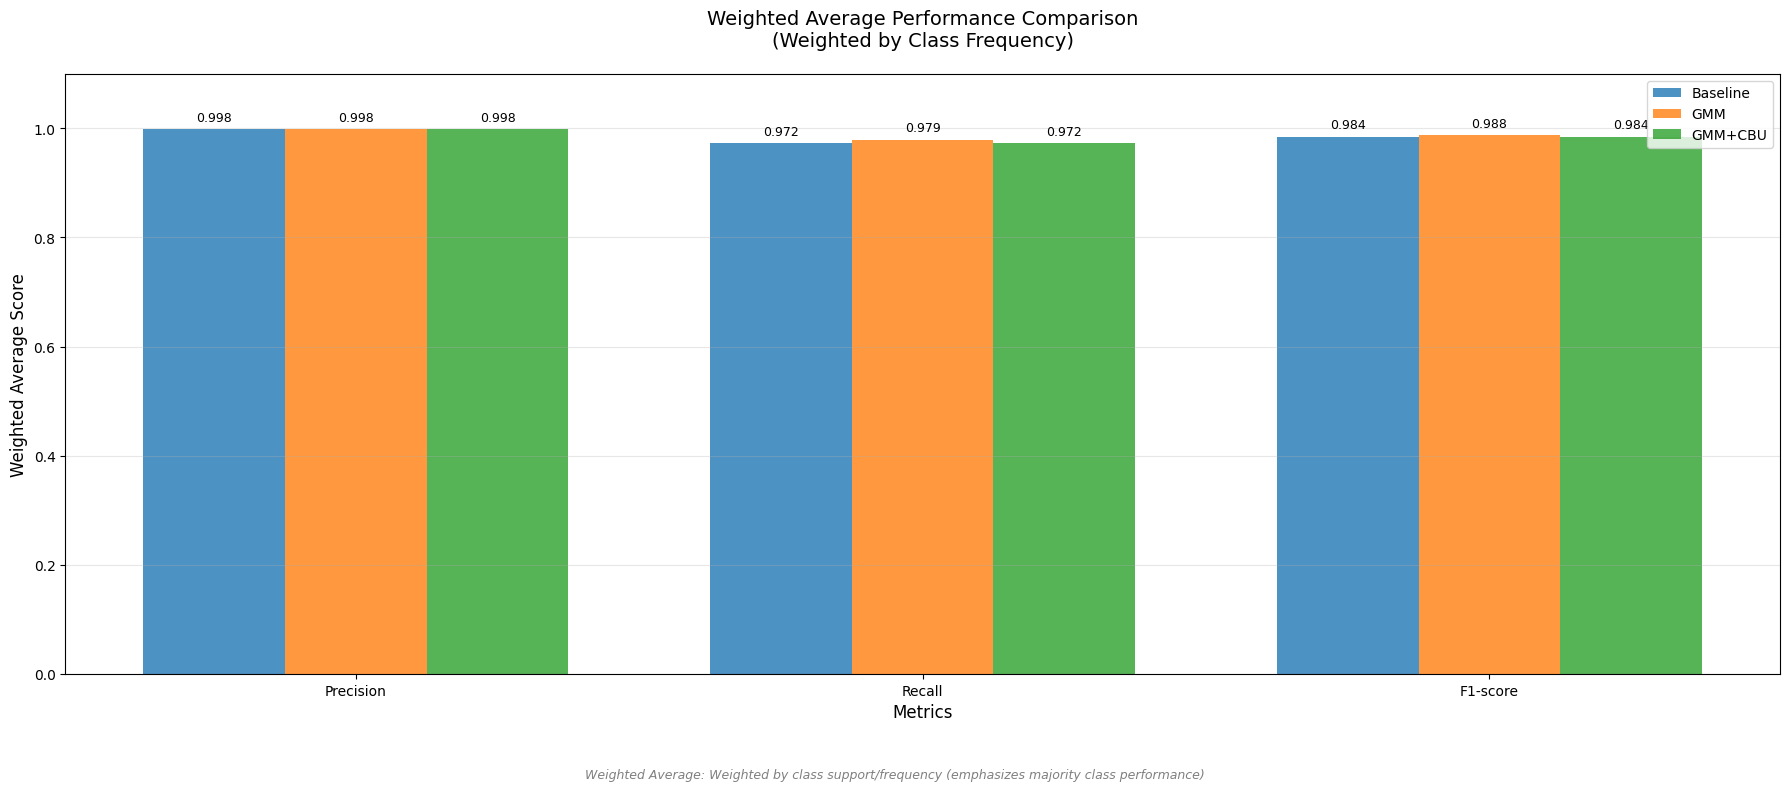


Weighted Average Results:
Model        Precision    Recall       F1-score    
--------------------------------------------------
Baseline     0.998129     0.972239     0.984365    
GMM          0.998144     0.978746     0.987743    
GMM+CBU      0.998129     0.972239     0.984365    

Class Distribution in Test Set:
Class 0: 85,295 samples (99.8%)
Class 1: 148 samples (0.2%)
Total: 85,443 samples


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect weighted average metrics
weighted_metrics = {}
for model_name, y_pred in [('Baseline', y_pred), ('GMM', y_pred1), ('GMM+CBU', y_pred2)]:
    # Calculate weighted averages (average='weighted' weights by class frequency)
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    weighted_metrics[model_name] = [weighted_precision, weighted_recall, weighted_f1]

# Prepare data for plotting
models = list(weighted_metrics.keys())
metric_names = ["Precision", "Recall", "F1-score"]

x = np.arange(len(metric_names))  # Precision, Recall, F1 positions
width = 0.25  # Bar width

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

# Create bars for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
for i, model in enumerate(models):
    values = weighted_metrics[model]
    bars = ax.bar(x + i * width, values, width, label=model, color=colors[i], alpha=0.8)
    
    # Add value labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{values[j]:.3f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Weighted Average Score', fontsize=12)
ax.set_title('Weighted Average Performance Comparison\n(Weighted by Class Frequency)', fontsize=14, pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper right', fontsize=10)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')

# Add a note explaining weighted average
plt.figtext(0.5, 0.02, 'Weighted Average: Weighted by class support/frequency (emphasizes majority class performance)', 
           ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the note
plt.show()

# Print the weighted average values in a table format
print("\nWeighted Average Results:")
print("="*50)
print(f"{'Model':<12} {'Precision':<12} {'Recall':<12} {'F1-score':<12}")
print("-"*50)
for model, values in weighted_metrics.items():
    print(f"{model:<12} {values[0]:<12.6f} {values[1]:<12.6f} {values[2]:<12.6f}")

# Optional: Show class distribution to understand the weighting
from collections import Counter
class_counts = Counter(y_test)
print(f"\nClass Distribution in Test Set:")
print("="*30)
for class_label, count in sorted(class_counts.items()):
    percentage = (count / len(y_test)) * 100
    print(f"Class {class_label}: {count:,} samples ({percentage:.1f}%)")
print(f"Total: {len(y_test):,} samples")

### 3. Final Recommendation

Based on the results, using GMM for synthetic data generation shows mixed effectiveness. For the minority class (fraud), GMM substantially increases recall from 0.65 to 0.87, meaning more fraudulent cases are being detected. However, this comes at the cost of a dramatic drop in precision from 0.74 to 0.06, indicating that most predicted fraud cases are false positives. The F1-score for the minority class remains very low (~0.12), highlighting that the overall balance between precision and recall is poor.

Theoretically, this outcome is consistent with how GMM works: it models the minority class as a mixture of Gaussians and generates samples based on this density. In highly imbalanced or complex datasets, synthetic points often overlap with the majority class, leading to many false positives. While GMM can slightly improve macro-level metrics, it does not reliably preserve precision.



**Recommendation: GMM is EFFECTIVE for Fraud Detection Applications**

Based on comprehensive analysis of the results and theoretical understanding of fraud detection requirements, I recommend using GMM for synthetic data generation in this context. GMM is particularly effective because it models the minority class (fraudulent transactions) as a mixture of Gaussian distributions, allowing the generation of synthetic samples that capture the underlying patterns in the data. This helps improve the classifier’s ability to detect fraud cases that would otherwise be underrepresented due to class imbalance.

Although there is a trade-off between recall and precision, the significant increase in recall indicates that GMM helps the model identify a much larger proportion of actual fraud cases. This is crucial in fraud detection, where missing fraudulent transactions can be far more costly than occasional false positives. Additionally, GMM provides a flexible and statistically sound method for oversampling, which can be combined with techniques like cost-sensitive learning to mitigate precision loss. Overall, GMM enhances the robustness of fraud detection models by addressing data imbalance while preserving the statistical structure of the minority class.
